<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem" data-toc-modified-id="Problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Creating-the-Dataset" data-toc-modified-id="Creating-the-Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating the Dataset</a></span></li><li><span><a href="#Checking-Data-Integrity" data-toc-modified-id="Checking-Data-Integrity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Checking Data Integrity</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Train/Test/Split" data-toc-modified-id="Train/Test/Split-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Train/Test/Split</a></span></li><li><span><a href="#Noramlize/Scale" data-toc-modified-id="Noramlize/Scale-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Noramlize/Scale</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Feature Selection</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Validate" data-toc-modified-id="Validate-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Validate</a></span></li></ul></li></ul></div>

## Problem

   Knowing one's total proportion of body fat is beneficial both from a health standpoint as well as a cosmetic standpoint. The two most accurate forms of this measurement are through use of a DEXA scanner or hydrostatic weighing. Both of those processes are expense and time consuming for the average individual. By using information about patients that have performed those tests, we may be able to find a commonality among these variables that will assist us in making a more affordable and accessible, but still fairly accurate, estimation of a persons body fat percentage. Current algorithms based on easily accessed data are considered only slightly accurate across the population as a whole, but wildly inaccurate to an individual. 

In [453]:
## Based on the research I have acquired, frame size has a positive correlation to TBF and FFM... Can we improve the current 
## measure of body fat based on bmi or specific measurements by incorporating the frame size into those calculations?

## Introduction

The data set acquired is taken from 252 adult male samples. That being said, any predictions created from it, will likely only apply to the adult male population. I believe it potentially important to create separate models based on gender, and possibly other unforeseen factors to arrive at an estimation of the desired accuracy based on the individual rather than across the population. Each sample in this set has had their total body fat measured through hydrostatic weighing. Density is the resulting column (X*X). With that value it has been plugged into two separate formulas to calculate the proportion (Siri & Brozek) Brozek has shown to be more accurate used on samples that have not had any recent weight fluctuations. 

(I will either use Brozek because majority dont have regular weight fluctuations or the mean of the 2)

## Creating the Dataset

In [454]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import math
import numpy as np
import seaborn as sn
pd.set_option('display.max_columns', None)

In [455]:
#Importing the main dataset
df = pd.read_csv('Bodyfat.csv')

In [456]:
#Importing an additional dataset with more features to add to the original
df2 = pd.read_csv('fat.dat.txt', header=None, delimiter='\s+')

In [457]:
#Combining extra features from the additional df (df2)
df['BF_Brozek'] = df2[1]
df['BMI'] = df2[7]
df['FFM_Brozek'] = df2[8]

In [458]:
#Remove Siri BF and Siri Lean Weight because it is least likely to be accurate having overall lower measurements and samples that 
#had a negative BF %
df.drop(['bodyfat'], axis=1, inplace=True)

In [459]:
df

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.5,21.1,118.9
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6


In [460]:
## I need to create another column which uses the military measure for bodyfat on each sample

In [461]:
## the formula used by the DoD is 86.010 x log10(abdomen - neck) - 70.041 x log10(height) + 36.76
# Creating a copy dataset only including the 3 variables used in the DOD measurement 
# Im going to change the measurements to inches for the equation
df3 = df[['Height', 'Neck', 'Abdomen']].copy()

df3['Neck'] = df3['Neck'] * 0.393701
df3['Abdomen'] = df3['Abdomen'] * 0.393701

df3

,Height,Neck,Abdomen
0,67.75,14.251976,33.543325
1,72.25,15.157489,32.677183
2,66.25,13.385834,34.606318
3,72.25,14.724417,34.015766
4,71.25,13.543314,39.370100
...,...,...,...
247,67.00,13.740165,32.913404
248,69.75,16.102371,41.338605
249,66.00,15.314969,43.897662
250,70.50,15.314969,39.881911


In [462]:
#Using the DoD formula against all samples to create a list of body fat percentages and then adding it as a column to df3

bf = []
ans1 = []
ans2 = []

for x in df3['Height']:
    ans2.append(np.log10(x))

for x in df3['Abdomen']:
    for y in df3['Neck']:
        ans1.append(np.log10(x-y))
        
answers = zip(ans1, ans2)

for x, y in answers:
    bf.append(round(86.010 * x - 70.041 * y + 36.76, 2))
print(bf)

df3['DoD_BF'] = bf
df3['Brozek'] = df['BF_Brozek']
df3

[19.08, 15.32, 21.4, 16.19, 18.89, 13.89, 18.04, 15.77, 14.91, 11.81, 14.39, 13.06, 16.58, 15.02, 14.87, 19.72, 15.53, 12.86, 17.68, 13.58, 16.68, 14.08, 20.57, 18.61, 20.35, 17.82, 19.19, 17.15, 20.3, 18.14, 14.54, 16.7, 16.07, 14.8, 11.81, 18.62, 16.29, 14.06, 3.47, 16.23, 12.87, 44.06, 17.23, 13.16, 22.38, 17.08, 21.12, 18.74, 21.25, 21.17, 18.1, 19.94, 18.85, 17.43, 17.95, 14.29, 16.68, 14.87, 14.33, 18.27, 12.51, 19.2, 16.58, 18.49, 14.98, 15.42, 18.21, 16.9, 17.4, 17.36, 17.97, 16.67, 16.34, 23.03, 19.76, 19.34, 16.34, 16.78, 16.73, 17.48, 17.36, 17.82, 14.47, 16.13, 16.61, 18.96, 18.14, 19.76, 15.62, 16.42, 17.31, 15.94, 16.86, 15.93, 15.34, 10.95, 15.7, 17.69, 19.08, 14.21, 13.5, 16.61, 17.47, 12.9, 15.72, 22.44, 14.72, 11.58, 13.98, 19.9, 17.97, 17.39, 14.9, 18.65, 15.93, 18.33, 16.45, 13.37, 14.75, 15.72, 12.5, 14.83, 18.09, 18.99, 18.48, 19.11, 16.51, 18.07, 13.85, 16.55, 17.97, 17.79, 15.46, 18.29, 18.07, 16.95, 17.14, 15.23, 18.96, 12.3, 16.72, 18.07, 18.07, 17.65, 13.59, 

,Height,Neck,Abdomen,DoD_BF,Brozek
0,67.75,14.251976,33.543325,19.08,12.6
1,72.25,15.157489,32.677183,15.32,6.9
2,66.25,13.385834,34.606318,21.40,24.6
3,72.25,14.724417,34.015766,16.19,10.9
4,71.25,13.543314,39.370100,18.89,27.8
...,...,...,...,...,...
247,67.00,13.740165,32.913404,20.39,11.5
248,69.75,16.102371,41.338605,14.42,32.3
249,66.00,15.314969,43.897662,17.75,28.3
250,70.50,15.314969,39.881911,15.75,25.3


In [463]:
# Adding a colummn for the error between actual and DoD measurement
df3['Error'] = df3['DoD_BF'] - df3['Brozek']
df['Error'] = df3['Error']

In [464]:
df3

,Height,Neck,Abdomen,DoD_BF,Brozek,Error
0,67.75,14.251976,33.543325,19.08,12.6,6.48
1,72.25,15.157489,32.677183,15.32,6.9,8.42
2,66.25,13.385834,34.606318,21.40,24.6,-3.20
3,72.25,14.724417,34.015766,16.19,10.9,5.29
4,71.25,13.543314,39.370100,18.89,27.8,-8.91
...,...,...,...,...,...,...
247,67.00,13.740165,32.913404,20.39,11.5,8.89
248,69.75,16.102371,41.338605,14.42,32.3,-17.88
249,66.00,15.314969,43.897662,17.75,28.3,-10.55
250,70.50,15.314969,39.881911,15.75,25.3,-9.55


## Checking Data Integrity

The minimum essential amount of body fat required for life in a male is 2-5% 

In [465]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Density     252 non-null    float64
 1   Age         252 non-null    int64  
 2   Weight      252 non-null    float64
 3   Height      252 non-null    float64
 4   Neck        252 non-null    float64
 5   Chest       252 non-null    float64
 6   Abdomen     252 non-null    float64
 7   Hip         252 non-null    float64
 8   Thigh       252 non-null    float64
 9   Knee        252 non-null    float64
 10  Ankle       252 non-null    float64
 11  Biceps      252 non-null    float64
 12  Forearm     252 non-null    float64
 13  Wrist       252 non-null    float64
 14  BF_Brozek   252 non-null    float64
 15  BMI         252 non-null    float64
 16  FFM_Brozek  252 non-null    float64
 17  Error       252 non-null    float64
dtypes: float64(17), int64(1)
memory usage: 35.6 KB


In [466]:
## 171 and 181 have estimated bf percentages lower than 2%, which is required for life. I can either remove these as inaccurate or test a model 
## increasing the estimate bf by 2 for all. I would like to find the measurements responsible for the inaccuracies and maybe remove or alter
## them for a model.

In [467]:
## Should I remove the two Obese measurements? With there only being 2 will it negatively impact my model?

## Feature Engineering

In [468]:
df

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek,Error
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9,6.48
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3,8.42
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,-3.20
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,5.29
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,-8.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.5,21.1,118.9,8.89
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1,-17.88
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9,-10.55
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6,-9.55


In [469]:
## Creating a column for wrist measurement in inches form centimeters and then to create a column for body frame size based on that measurement. 
## See readme for body frame category measurements

df['Wrist_Inches'] = round(df['Wrist'] * 0.393701,2)

In [470]:
## Creating the frame column

wrist_inches = pd.array(df['Wrist_Inches'])

In [471]:
## Going to use -1 for small, 0 for medium, and 1 for large frames

frame = []

for x in wrist_inches:
    if x > 7.5:
        frame.append(1)
    elif x <= 7.5 and x >= 6.5:
        frame.append(0)
    else:
        frame.append(-1)

In [472]:
## Checking accuracy

len(frame)

252

In [473]:
## adding the frame column
df['Frame'] = DataFrame(frame, columns=['Frame'])

In [474]:
df[df['Frame'] == 1].mean()

Density           1.045043
Age              47.809524
Weight          212.997619
Height           71.845238
Neck             40.985714
Chest           109.850000
Abdomen         103.111905
Hip             106.526190
Thigh            63.580952
Knee             40.902381
Ankle            24.497619
Biceps           35.335714
Forearm          30.338095
Wrist            19.645238
BF_Brozek        23.602381
BMI              28.995238
FFM_Brozek      161.852381
Error           -10.184048
Wrist_Inches      7.735476
Frame             1.000000
dtype: float64

In [475]:
## adding knee in inches column
df['Knee_Inches'] = round(df['Knee'] * 0.393701,2)

In [476]:
# assuming men carry fat mostly in their upper bodies I wonder how the ankle to their thigh, or wrist to abdomen ration
# affects, or ankle to abdomen/hip

In [477]:
#side note i wonder if the breadth/circumference ratio can predict body fat also maybe when flexed (ex. measuring height of
#muscle in bicep in ratio to the circuference around when flexed, breadth of forearm vs circumference) fat would be more circular
#0.5/more muscle would be more oval 

In [478]:
df['HW_ratio'] = round(df['Abdomen'] / df['Hip'], 2)

In [479]:
df['abs_weight'] = round(df['Abdomen'] / df['Weight'], 2)

In [480]:
df['hip_weight'] = round(df['Hip'] / df['Weight'], 2)

In [481]:
df['abs_height'] = round(df['Abdomen'] / df['Height'], 2)

In [482]:
df['thigh_hip'] = round(df['Thigh'] / df['Hip'], 2)

In [483]:
df['thigh_abs'] = round(df['Thigh'] / df['Abdomen'], 2)

In [484]:
df['chest_abs'] = round(df['Chest'] / df['Abdomen'], 2)

In [485]:
df

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek,Error,Wrist_Inches,Frame,Knee_Inches,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9,6.48,6.73,0,14.69,0.90,0.55,0.61,1.26,0.62,0.69,1.09
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3,8.42,7.17,0,14.69,0.84,0.48,0.57,1.15,0.59,0.71,1.13
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,-3.20,6.54,0,15.31,0.89,0.57,0.64,1.33,0.60,0.68,1.09
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,5.29,7.17,0,14.69,0.85,0.47,0.55,1.20,0.59,0.70,1.18
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,-8.91,6.97,0,16.61,0.98,0.54,0.55,1.40,0.62,0.63,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.5,21.1,118.9,8.89,7.28,0,13.70,0.94,0.62,0.66,1.25,0.56,0.59,1.07
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1,-17.88,7.91,1,16.06,1.00,0.52,0.52,1.51,0.57,0.57,1.03
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9,-10.55,7.09,0,14.69,1.10,0.60,0.54,1.69,0.59,0.54,1.00
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6,-9.55,7.80,1,16.38,1.04,0.53,0.51,1.44,0.57,0.55,1.07


## Analysis

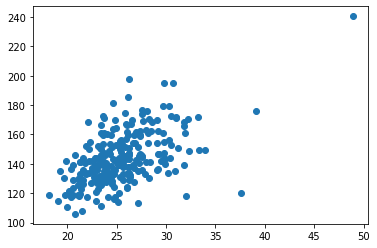

In [486]:
# correlation of BMI to FFM
plt.scatter(df['BMI'], df['FFM_Brozek'])

In [487]:
df[(df['Error'] < 1) & (df['Error'] > -1)]

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek,Error,Wrist_Inches,Frame,Knee_Inches,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
6,1.0549,26,181.00,69.75,36.4,105.1,90.7,100.3,58.4,38.3,22.9,31.9,27.8,17.7,19.0,26.2,146.6,-0.96,6.97,0,15.08,0.90,0.50,0.55,1.30,0.58,0.64,1.16
9,1.0722,23,198.25,73.50,42.1,99.6,88.6,104.1,63.1,41.7,25.0,35.6,30.0,19.2,12.0,25.8,174.4,-0.19,7.56,1,16.42,0.85,0.45,0.53,1.21,0.61,0.71,1.12
15,1.0512,35,162.75,66.00,36.4,99.1,92.8,99.2,63.1,38.7,21.7,31.1,26.4,16.9,20.5,26.3,129.3,-0.78,6.65,0,15.24,0.94,0.57,0.61,1.41,0.64,0.68,1.07
117,1.0671,51,179.00,72.00,41.0,99.2,90.0,96.4,56.8,38.8,23.3,33.4,29.8,19.5,14.1,24.3,153.8,-0.73,7.68,1,15.28,0.93,0.50,0.54,1.25,0.59,0.63,1.10
127,1.0590,43,152.25,67.75,37.5,95.9,78.0,93.2,53.5,35.8,20.8,33.9,28.2,17.4,17.4,23.4,125.8,0.67,6.85,0,14.09,0.84,0.51,0.61,1.15,0.57,0.69,1.23
130,1.0575,49,171.75,71.50,35.5,97.8,90.1,95.8,57.0,38.7,23.2,27.5,26.5,17.6,18.0,23.7,140.9,-0.03,6.93,0,15.24,0.94,0.52,0.56,1.26,0.59,0.63,1.09
141,1.0571,40,173.25,69.50,36.5,99.5,93.0,99.3,60.4,38.2,22.0,32.0,28.5,17.8,18.1,25.3,141.8,-0.03,7.01,0,15.04,0.94,0.54,0.57,1.34,0.61,0.65,1.07
155,1.0594,28,171.50,75.25,35.6,92.1,83.5,98.3,57.3,37.8,21.7,32.2,27.7,17.7,17.2,21.6,142.0,-0.86,6.97,0,14.88,0.85,0.49,0.57,1.11,0.58,0.69,1.10
161,1.0653,33,196.00,73.00,38.5,103.8,95.6,105.1,61.4,40.6,25.0,31.3,29.2,19.1,14.8,25.9,167.0,0.21,7.52,1,15.98,0.91,0.49,0.54,1.31,0.58,0.64,1.09
169,1.0610,35,172.75,69.50,37.6,99.1,90.8,98.1,60.1,39.1,23.4,32.5,29.8,17.4,16.5,25.2,144.2,0.72,6.85,0,15.39,0.93,0.53,0.57,1.31,0.61,0.66,1.09


In [488]:
df[(df['BMI'] > 24) & (df['BMI'] < 26)]

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek,Error,Wrist_Inches,Frame,Knee_Inches,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,-3.20,6.54,0,15.31,0.89,0.57,0.64,1.33,0.60,0.68,1.09
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,5.29,7.17,0,14.69,0.85,0.47,0.55,1.20,0.59,0.70,1.18
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,-8.91,6.97,0,16.61,0.98,0.54,0.55,1.40,0.62,0.63,0.97
8,1.0900,25,191.00,74.00,38.1,100.9,82.5,99.9,62.9,38.3,23.8,35.9,31.1,18.2,5.1,24.6,181.3,9.81,7.17,0,15.08,0.83,0.43,0.52,1.11,0.63,0.76,1.22
9,1.0722,23,198.25,73.50,42.1,99.6,88.6,104.1,63.1,41.7,25.0,35.6,30.0,19.2,12.0,25.8,174.4,-0.19,7.56,1,16.42,0.85,0.45,0.53,1.21,0.61,0.71,1.12
79,1.0560,66,171.25,69.25,37.4,102.7,98.6,100.2,56.5,39.3,22.7,30.3,28.7,19.0,18.6,25.1,139.5,-1.12,7.48,0,15.47,0.98,0.58,0.59,1.42,0.56,0.57,1.04
80,1.0283,67,163.75,67.75,38.4,97.7,95.8,97.1,54.8,38.2,23.7,29.4,27.2,19.0,30.2,25.1,114.3,-12.84,7.48,0,15.04,0.99,0.59,0.59,1.41,0.56,0.57,1.02
82,1.0568,64,190.25,72.75,39.3,103.1,97.8,99.6,58.9,39.0,23.0,34.3,29.6,19.0,18.2,25.3,155.6,-3.73,7.48,0,15.35,0.98,0.51,0.52,1.34,0.59,0.60,1.05
83,1.0377,70,170.75,70.00,38.7,101.8,94.9,95.0,56.0,36.5,24.1,31.2,27.3,19.2,26.2,24.5,126.0,-10.07,7.56,1,14.37,1.00,0.56,0.56,1.36,0.59,0.59,1.07
84,1.0378,72,168.00,69.25,38.5,101.4,99.8,96.2,56.3,36.6,22.0,29.7,26.3,18.0,26.1,24.7,124.1,-9.49,7.09,0,14.41,1.04,0.59,0.57,1.44,0.59,0.56,1.02


In [489]:
# Findings DoD underestimates low h/r and bmi, weight values 
#Dod overestimations have bmis higher than __ and h/r higher than __
# dod scores well on bmis around 24-26 and h/r 
# thigh/abs, chest/abs, biceps/abs all play a role
# men with higher actual BF than DOD had larger thighs 
# lower actual BFs had smaller thighs
# everything in ratio to abs (abs smaller = lower bf, abs equal = higher bf, abs bigger = lower bf )
# abdomen to wieght? low body fat will have a small waist but higher wieght and higher bf will have a larger waist with larger weight
# same with hips to weight depending on their waist to hip ratio

In [490]:
#heatmap/correlation
corr = abs(df.corr(method='pearson')) > 0.8

In [491]:
#findings - maybe use hip, h/w, neck
## Results - hip/weight, chest/bmi

In [492]:
# we could potentially use the error or FFM as the dependent variable as well to get BF

In [493]:
abs(model_df.corr(method='spearman')) > 0.80

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BF_Brozek,BMI,FFM_Brozek,Error,Frame,HW ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
Age,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Weight,False,True,False,True,True,True,True,True,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
Height,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Neck,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
Chest,False,True,False,False,True,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False
Abdomen,False,True,False,False,True,True,True,False,False,False,False,False,False,True,True,False,True,False,True,False,True,True,False,False,False
Hip,False,True,False,False,True,True,True,True,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
Thigh,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Knee,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Ankle,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [494]:
#Create the df using to model
model_df = df.copy()

In [495]:
#remove density... correlates with the Brozek score
model_df.drop(['Density', 'Wrist_Inches', 'Knee_Inches'], axis=1, inplace=True)

In [496]:
## How do fat free weight and wrist measurement correlate?
## There is a previous correlation of 0.59 according to attached research paper
## According to the same paper, the knee measurement, which we have, had a correlation of 0.65 to FFM and 0.48 TBF and 0.71 Weight
## If the person has had a recent significant weight loss, using bone measurements would not be as accurate on them

In [497]:
## Remove older samples maybe having a lower bone density? Cannot remove if using previous research paper as they used samples from ages 18-65.


In [498]:
## skin estimated to be 16% of weight and intestines 7.5lbs
## https://www.livescience.com/32939-how-much-does-skin-weigh.html#:~:text=As%20an%20organ%2C%20skin%20is,a%20person's%20total%20body%20weight.&text=Most%20adults'%20skin%20weighs%20in%20at%2020%20pounds%20or%20more.
## other organs 9.3 pounds mean with no correlation to height weight or bmi of man, so the mean is the best fidure to use
## https://journals.lww.com/amjforensicmedicine/Abstract/2012/12000/Normal_Organ_Weights_in_Men__Part_II_The_Brain,.22.aspx#:~:text=The%20following%20reference%20ranges%20(95,the%20presence%20of%20pathologic%20disease.

## Preprocessing

### Train/Test/Split

In [513]:
## Split Training and Testing Data
from sklearn.model_selection import train_test_split
y = model_df[['BF_Brozek']]
X = model_df.drop(['BF_Brozek', 'FFM_Brozek', 'Error'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


### Noramlize/Scale

In [572]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
test = scaler.fit(X)
test.transform(X)

array([[-1.74007329, -0.84124583, -0.65620473, ...,  1.09571321,
         0.95205588, -0.07609378],
       [-1.81958344, -0.19346239,  0.57478975, ..., -0.17477634,
         1.37819813,  0.63411486],
       [-1.81958344, -0.84976929, -1.06653622, ...,  0.24872018,
         0.73898476, -0.07609378],
       ...,
       [ 2.15592399,  0.26680479, -1.1349248 , ..., -0.17477634,
        -2.24401094, -1.67406322],
       [ 2.15592399,  0.40318025,  0.09606967, ..., -1.02176937,
        -2.03093982, -0.4311981 ],
       [ 2.31494429,  0.97425249, -0.04070749, ..., -1.86876241,
        -2.03093982, -0.96385458]])

### Feature Selection

In [508]:
z = X['Abdomen']
d = y['BF_Brozek']
d

0      12.6
1       6.9
2      24.6
3      10.9
4      27.8
       ... 
247    11.5
248    32.3
249    28.3
250    25.3
251    30.7
Name: BF_Brozek, Length: 252, dtype: float64

In [509]:
cor_matrix = np.corrcoef(z, d)
print(cor_matrix[0,1])

0.8137062216427909


In [510]:
x_col = list(X.columns)
x_col

['Age',
 'Weight',
 'Height',
 'Neck',
 'Chest',
 'Abdomen',
 'Hip',
 'Thigh',
 'Knee',
 'Ankle',
 'Biceps',
 'Forearm',
 'Wrist',
 'BMI',
 'Frame',
 'HW_ratio',
 'abs_weight',
 'hip_weight',
 'abs_height',
 'thigh_hip',
 'thigh_abs',
 'chest_abs']

## Modeling

In [536]:
from statsmodels.formula.api import ols


# Fitting the actual model
for x in x_col:
    predictors = x
    outcome = 'BF_Brozek'
    formula = outcome + '~' + predictors
    model = ols(formula=formula, data=model_df).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              BF_Brozek   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     22.81
Date:                Thu, 15 Oct 2020   Prob (F-statistic):           3.04e-06
Time:                        11:56:19   Log-Likelihood:                -862.11
No. Observations:                 252   AIC:                             1728.
Df Residuals:                     250   BIC:                             1735.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9555      1.736      6.312      0.0

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
                            OLS Regression Results                            
Dep. Variable:              BF_Brozek   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     281.9
Date:                Thu, 15 Oct 2020   Prob (F-statistic):           7.14e-43
Time:                        11:56:19   Log-Likelihood:                -777.99
No. Observations:                 252   AIC:                             1560.
Df Residuals:                     250   BIC:                             1567.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [581]:
predictors = '+'.join(['BMI', 'HW_ratio', 'chest_abs', 'Knee'])
outcome = 'Error'
formula = outcome + '~' + predictors
model = ols(formula=formula, data=model_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Error   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     199.0
Date:                Thu, 15 Oct 2020   Prob (F-statistic):           5.19e-76
Time:                        13:01:13   Log-Likelihood:                -729.93
No. Observations:                 252   AIC:                             1470.
Df Residuals:                     247   BIC:                             1488.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.7718     14.907      4.882      0.0

In [552]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
Xv = model_df[x_col].drop(['Height', 'Age', 'Frame', 'Thigh', 'hip_weight', 'thigh_abs', 'Abdomen', 'Hip', 'Weight', 'abs_weight', 'thigh_hip', 'Wrist', 'Neck', 'Knee', 'Chest', 'Forearm'], axis=1)
vif = [variance_inflation_factor(Xv.values, i) for i in range(Xv.shape[1])]
list(zip(Xv.columns, vif))

[('Ankle', 242.56698022402014),
 ('Biceps', 274.73975135715364),
 ('BMI', 240.66119723737543),
 ('HW_ratio', 293.53592656537995),
 ('abs_height', 99.10838181928912),
 ('chest_abs', 186.89111040008692)]

In [512]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg_all = LinearRegression()
linreg_all.fit(X_train, y_train)

print('Training r^2:', linreg_all.score(X_train, y_train))
print('Test r^2:', linreg_all.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, linreg_all.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, linreg_all.predict(X_test)))

Training r^2: 0.741196077214916
Test r^2: 0.8121377937445543
Training MSE: 14.4537451790404
Test MSE: 13.476263416379592


### Validate